In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pyspark.sql import SparkSession
import pyspark.pandas as spd
from pyspark.sql import functions as sfunc
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

from scipy.stats import linregress, gaussian_kde

import skgstat as skg
from pylr2 import regress2
from biomassrecovery.spark.gedi_recovery_analysis_pipeline_monte_carlo import FileInterface


/home/ah2174/biomass-recovery/src/data/jrc_loading.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
path = pathlib.Path('/maps/forecol/data/Overlays/monte_carlo')
fi = FileInterface(path)

In [4]:
metadata = pd.read_feather(path / 'chunk_metadata.feather')
metadata

,token,year,has_data,error,error_message
0,S18_W64,2019,True,False,None
1,S17_W68,2019,False,False,None
2,S17_W67,2019,False,False,None
3,S17_W66,2019,True,False,None
4,S17_W65,2019,True,False,None
...,...,...,...,...,...
1870,N8_W59,2021,True,False,None
1871,N9_W63,2021,True,False,None
1872,N9_W62,2021,True,False,None
1873,N9_W61,2021,False,False,None


In [5]:
spark = (
    SparkSession.builder.config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "10g")
    .getOrCreate()
)

22/11/29 15:37:20 WARN Utils: Your hostname, sherwood resolves to a loopback address: 127.0.1.1; using 128.232.113.32 instead (on interface external)
22/11/29 15:37:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/29 15:37:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
sdf = spd.read_parquet((path / "results/std1/filtered").as_posix(), index_col='__index_level_0__')

In [7]:
print(sdf.shape)
print(sdf.columns)


(149583, 2014)
Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'l2_quality_flag',
       'l4_quality_flag',
       ...
       'a_990', 'a_991', 'a_992', 'a_993', 'a_994', 'a_995', 'a_996', 'a_997',
       'a_998', 'a_999'],
      dtype='object', length=2014)


In [112]:
print(type(sdf))
sdf_sub = sdf[sdf.shot_number == 80230800100106532]
print(len(sdf_sub))
print(sdf_sub[['lon_lowestmode', 'lat_lowestmode']])

<class 'pyspark.pandas.frame.DataFrame'>


1


                   lon_lowestmode  lat_lowestmode
__index_level_0__                                
7292                   -47.610116       -4.981465


/home/ah2174/biomass-recovery/venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


167474


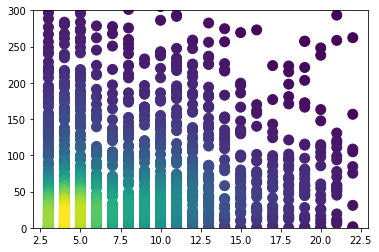

In [240]:
data = sdf[['shot_number', 'a_0', 'r_0']].to_pandas()
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# qg = quality_gedi[quality_gedi.overlap_quality == 5]
qg = data.dropna()
qg = qg[(qg.r_0 >=3) & (qg.r_0 <= 22) ]
print(len(qg))
n = len(qg)
sample = np.random.choice(n, size=int(n/100), replace=False)
x = qg.r_0.iloc[sample].values
y = qg.a_0.iloc[sample].values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
ax.set_ylim([0,300])
plt.show()

/home/ah2174/biomass-recovery/venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


363123


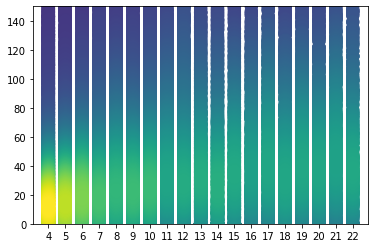

In [238]:
data = sdf[['shot_number', 'a_0', 'r_0']].to_pandas()
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# qg = quality_gedi[quality_gedi.overlap_quality == 5]
qg = data.dropna()
qg = qg[(qg.r_0 >=3) & (qg.r_0 <= 22) ]
print(len(qg))
n = len(qg)
sample = np.random.choice(n, size=int(n/10), replace=False)
x = qg.r_0.iloc[sample].values
y = qg.a_0.iloc[sample].values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=150)
ax.set_xticks(ages)
ax.set_ylim([0,150])
plt.show()

In [34]:
print(qg[qg.r_0 == 22])

                          shot_number         a_0   r_0
__index_level_0__                                      
10637              100820300100104491   84.405143  22.0
11165               93500000100105501   32.444957  22.0
1180                33850200100105469  148.116551  22.0
4077                33850200100105470  283.578049  22.0
1575                44230600100212982  429.404559  22.0
...                               ...         ...   ...
18                  43390200300500155   55.367177  22.0
27                  49270300100082302   14.699806  22.0
6                   28591100400244744  941.162989  22.0
4                   42180100400368591   31.678146  22.0
18                 137580600100247968  667.245095  22.0

[868 rows x 3 columns]


Index(['shot_number', 'a_0', 'recovery_period', 'agcd'], dtype='object')


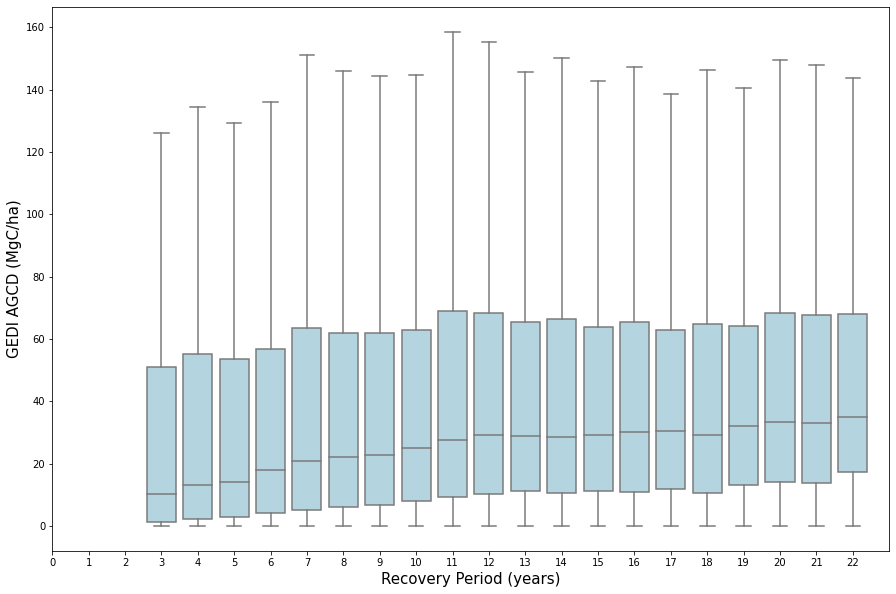

In [28]:
quality_gedi = data[(data.r_0 >= 3) & (data.r_0 <= 22)].rename(columns={
    'r_0': 'recovery_period',
})
quality_gedi['agcd'] = 0.48 * quality_gedi['a_0']
print(quality_gedi.columns)
plt.figure(1, (15,10))
ax = sns.boxplot(x="recovery_period", y="agcd", data=quality_gedi, color='lightblue', showfliers=False, order=np.arange(23))
ax.set_ylabel("GEDI AGCD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])
xs = np.arange(0, 23)

In [12]:
## TO FREE UP MEMORY:
del(sdf)

In [11]:
hist = pd.concat(
    [
        fi.load_data(token=row.token, year=row.year, data_type='hist') 
        for _, row in metadata[metadata.has_data == True].iterrows()
    ],
    ignore_index=True
)
shotinfo = pd.concat(
    [
        fi.load_data(token=row.token, year=row.year, data_type='shotinfo') 
        for _, row in metadata[metadata.has_data == True].iterrows()
    ],
    ignore_index=True
)

df_join = (hist).merge(shotinfo, on="shot_number")

In [12]:
print(len(df_join))
df_join.to_feather(path / 'results/nonan/master_summary_allyears.feather')

214944


In [6]:
hist['std'].describe()
hist['mode_vals'].describe()
hist['mode_counts'].describe()
hist['mean'].describe()
hist['min'].describe()

count    149583.000000
mean          7.454751
std           7.332243
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max          37.000000
Name: min, dtype: float64

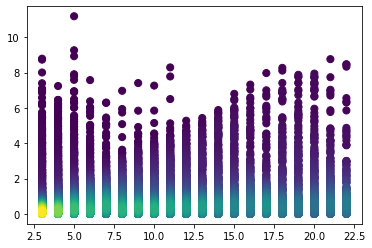

In [76]:
# "canonical" age will be the mode
qg = df[(df.mode_vals >=3) & (df.mode_vals <= 22) ]
n = len(qg)
sample = np.random.choice(n, size=int(n/10), replace=False)
x = qg['mode_vals'].iloc[sample].values
y = qg['std'].iloc[sample].values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
#ax.set_ylim([0,10])
plt.show()

167856
53538


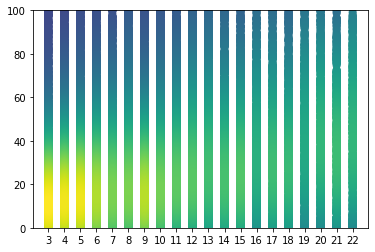

In [22]:
# df_join = data.merge(df, on='shot_number')
print(len(df_join))
qg = df_join
qg = qg[(qg.mode_vals >=3) & (qg.mode_vals <= 22)]
qg = qg[qg['std'] > 1]
print(len(qg))
n = len(qg)
sample = np.random.choice(n, size=int(n), replace=False)
x = qg.mode_vals.iloc[sample].values
y = qg.agbd.iloc[sample].values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
ax.set_ylim([0, 100])
ax.set_xticks(ages)
plt.show()

In [113]:
print(len(df_join[df_join['std'] > 6]))
print(df_join[df_join['std'] > 6].head(10))

1611
            shot_number         a_0   r_0   min   max   p75  median   p25  \
794   94720000100107125   41.647635   5.0   5.0  21.0  21.0     5.0   5.0   
1789  96550800100106069  163.604981  21.0  21.0  36.0  36.0    27.0  27.0   
2511  94110800100106074   84.981740  21.0  19.0  36.0  36.0    21.0  21.0   
2594  98380300100106451  121.727317  17.0   4.0  19.0  17.0     4.0   4.0   
2656  80230800100106532   88.438511  19.0   4.0  19.0  19.0    13.0   4.0   
3808  96550600100207440    0.000000   5.0   4.0  19.0  19.0    19.0   5.0   
4070  95330000100105580  185.386853  36.0  23.0  36.0  36.0    36.0  23.0   
4416  89150500400509927    1.729674   5.0   5.0  18.0  18.0     5.0   5.0   
9056  41330200100106365   79.789732   2.0   2.0  20.0  20.0    20.0  20.0   
9431  29880800100105461   75.889376  18.0   4.0  18.0  18.0    18.0   4.0   

        mean       std        var  mode_counts  mode_vals  
794   11.288  7.814669  61.069056        607.0        5.0  
1789  30.006  6.294280  39.